In [6]:
from collections import defaultdict

import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [18]:
DATA_DIR = "/Users/aleksandr/Desktop/recsys_made2023/botify_recsys/log/experiments/custom/"

In [20]:
data = pd.read_json(DATA_DIR + "data.json", lines=True).drop_duplicates(subset=["user", "track"])

In [21]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7

In [22]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [23]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

## Train LightFM

In [24]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(6563, 2410)

In [25]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [26]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [27]:
def fit_model(
    epochs=1, 
    at=10, 
    loss="warp", 
    no_components=30, 
    learning_rate=0.01, 
    max_sampled=10, 
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30, 
    verbose=False,
    patience=3,
    epsilon=1e-6
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
        
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopiing!")
            break
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]


In [28]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)
# best_params = study.best_params

best_params = {
    'loss': 'warp',
    'no_components': 50,
    'learning_rate': 0.01,
    'max_sampled': 50,
    'user_alpha': 0.0,
    'item_alpha': 0.0001
}

In [29]:
model, precisions_at = fit_model(
    epochs=200,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.01724598929286003 +/- 0.003240704235528677
1:	0.01711229979991913 +/- 0.0032759800207188593
2:	0.01724598929286003 +/- 0.00328286068498673
3:	0.01671122945845127 +/- 0.003255080400125758
4:	0.01724598929286003 +/- 0.0033244826568960195
5:	0.01778074912726879 +/- 0.0033717019596181826
6:	0.01818181946873665 +/- 0.003451517718519844
7:	0.018315507099032402 +/- 0.0034973767999078665
8:	0.018983958289027214 +/- 0.00344922656651011
9:	0.01885026879608631 +/- 0.0034028535644021235
10:	0.01925133727490902 +/- 0.00342156134649605
11:	0.01978609710931778 +/- 0.0034058369742959445
12:	0.019518716260790825 +/- 0.003433842850330096
13:	0.020053476095199585 +/- 0.003497495068416409
14:	0.020053476095199585 +/- 0.003517097739992581
15:	0.01978609524667263 +/- 0.003485648728620567
16:	0.01978609710931778 +/- 0.0034459740490392896
Early stopiing!


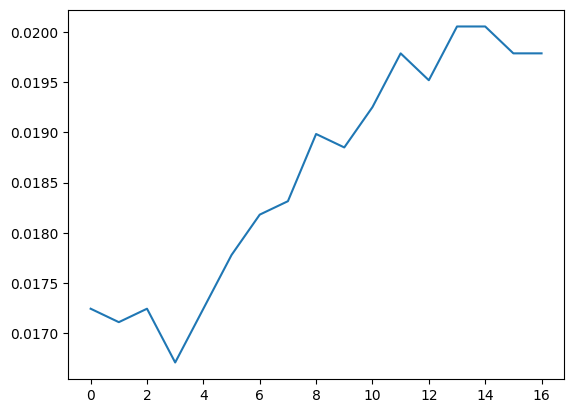

In [30]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [31]:
biases, embeddings = model.get_item_representations()

In [ ]:
model.item_biases *= 0.0

In [35]:
DATA_DIR = '/Users/aleksandr/Desktop/recsys_made2023/botify_recsys/data/'

In [36]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [37]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [38]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [39]:
k = 20
max_tracks_from_same_artist = 5

with open(DATA_DIR + f"recommendations_{k}_{max_tracks_from_same_artist}.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        j = track["dataset_index"]
        
        recommendations = []
        if pd.notna(j):
            embedding = embeddings[int(j)]
            neighbours = np.argsort(-np.dot(embeddings, embedding))
            
            artists = defaultdict(int)
            for neighbour in neighbours:
                recommended_track = dataset_tracks[dataset_tracks["dataset_index"] == neighbour].iloc[0]
                
                recommendation = int(recommended_track["track"])
                if recommendation == track["track"]:
                    continue
                
                artist = recommended_track["artist"]
                if artists[artist] >= max_tracks_from_same_artist:
                    continue
                
                recommendations.append(recommendation)
                artists[artist] += 1

                if len(recommendations) == k:
                    break
         
        track_with_recommendations = dict(track)
        track_with_recommendations["recommendations"] = recommendations
        
        rf.write(json.dumps(track_with_recommendations) + "\n")

50000it [00:05, 9024.54it/s] 


## How many unique artist per recommendation list?

In [40]:
dataset_track_artists = dict(zip(
    dataset_tracks["track"].values.tolist(),
    dataset_tracks["artist"].values.tolist(),
))

In [41]:
recs = pd.read_json(DATA_DIR + f"recommendations_{k}_{max_tracks_from_same_artist}.json", lines=True)
recs = recs[recs["dataset_index"].notnull()]

sample = recs.sample(frac=0.1).iloc[0]

print(sample["title"], "by" , sample["artist"], "\n===")
print("\n".join([dataset_track_artists[track] for track in sample["recommendations"]]))

Forever by Drake / Kanye West / Lil Wayne / Eminem 
===
California Swag District
Adam Lambert
B.o.B
Train
Harmonia
Young Money featuring Lloyd
Sean Kingston and Justin Bieber
Miley Cyrus
Jason Derulo
Taylor Swift
Travie McCoy
Charttraxx Karaoke
Björk
J. Karjalainen & Mustat Lasit
Lil Wayne / Eminem
John Mayer
Three Drives
Iyaz
Dwight Yoakam
Usher Featuring Lil' Jon & Ludacris


In [42]:
def count_artists(tracks):
    return len(
        set([dataset_track_artists[track] for track in tracks])
    )


artist_counts = recs["recommendations"].map(count_artists)
artist_counts.value_counts()

17    273
20    236
18     78
16     73
19     32
15      6
14      1
13      1
Name: recommendations, dtype: int64